In [124]:
# Import libraries and set constants
from dotenv import load_dotenv
import os
import mdai
from mdai.visualize import load_mask, display_images
import json
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import collections

DEBUG = False

load_dotenv('dot.env')

ACCESS_TOKEN = os.getenv('MDAI_TOKEN')
DATA_DIR = os.getenv('DATA_DIR')
DOMAIN = os.getenv('DOMAIN')
PROJECT_ID = os.getenv('PROJECT_ID')
DATASET_ID = os.getenv('DATASET_ID')
ANNOTATIONS = os.path.join(DATA_DIR, os.getenv('ANNOTATIONS'))
LABEL_ID = os.getenv('LABEL_ID')

print(f"ACCESS_TOKEN={ACCESS_TOKEN}")
print(f"DATA_DIR={DATA_DIR}")
print(f"DOMAIN={DOMAIN}")
print(f"PROJECT_ID={PROJECT_ID}")
print(f"DATASET_ID={DATASET_ID}")
print(f"ANNOTATIONS={ANNOTATIONS}")
print(f"LABEL_ID={LABEL_ID}")

# Start MD.ai client
mdai_client = mdai.Client(domain=DOMAIN, access_token=ACCESS_TOKEN)

# Download the dataset from MD.ai (or use cached version)
project = mdai_client.project(project_id=PROJECT_ID, path=DATA_DIR)

# Load the annotations
annotations_data = mdai.common_utils.json_to_dataframe(ANNOTATIONS)
annotations_df = pd.DataFrame(annotations_data['annotations'])
labels = annotations_df['labelId'].unique()

# Create the label map, LABEL_ID => 1, others in labels => 0
labels_dict = {LABEL_ID: 1}
project.set_labels_dict(labels_dict)

# Get the dataset
dataset = project.get_dataset_by_id(DATASET_ID)
dataset.classes_dict = project.classes_dict 

# Ensure BASE is set after preparing the dataset
BASE = dataset.images_dir

# Filter annotations for the free fluid label
free_fluid_annotations = annotations_df[annotations_df['labelId'] == LABEL_ID].copy()

# Function to construct the video path
def construct_video_path(base_dir, study_uid, series_uid):
    return os.path.join(base_dir, study_uid, f"{series_uid}.mp4")

# Add video paths to the dataframe using .loc to avoid the SettingWithCopyWarning
free_fluid_annotations['video_path'] = free_fluid_annotations.apply(
    lambda row: construct_video_path(BASE, row['StudyInstanceUID'], row['SeriesInstanceUID']), axis=1)

# Check if video files exist and add the result to the dataframe using .loc
free_fluid_annotations['file_exists'] = free_fluid_annotations['video_path'].apply(os.path.exists)

# Count the number of annotations with and without corresponding video files
num_with_files = free_fluid_annotations['file_exists'].sum()
num_without_files = len(free_fluid_annotations) - num_with_files

print(f"Annotations with corresponding video files: {num_with_files}")
print(f"Annotations without corresponding video files: {num_without_files}")

# Select five random annotations with corresponding video files
random_annotations = free_fluid_annotations[free_fluid_annotations['file_exists']].sample(n=5, random_state=42)



# Display function
def polygons_to_mask(polygons, height, width):
    mask = np.zeros((height, width), dtype=np.uint8)
    for polygon in polygons:
        points = np.array(polygon, dtype=np.int32)
        cv2.fillPoly(mask, [points], 1)
    return mask

def display_annotation(row):
    video_path = row['video_path']
    frame_number = int(row['frameNumber'])
    foreground = row['data']['foreground']
    video_id = row['SeriesInstanceUID']

    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()

    if not ret:
        print(f"Failed to read the frame number {frame_number} from the video.")
        return

    mask = polygons_to_mask(foreground, frame.shape[0], frame.shape[1])

    annotated_frame = frame.copy()
    annotated_frame[mask == 1] = (0, 0, 255)

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax[0].set_title(f'Video ID: {video_id}')
    ax[1].imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
    # ax[1].set_title(f'Annotated Frame (Video ID: {video_id}')
    plt.show()

ACCESS_TOKEN=d2b086facd41171613d918a9abefe499
DATA_DIR=data
DOMAIN=ucsf.md.ai
PROJECT_ID=x9N2LJBZ
DATASET_ID=D_V688LQ
ANNOTATIONS=data/mdai_ucsf_project_x9N2LJBZ_annotations_2024-06-27-212520.json
LABEL_ID=L_13yPql
Successfully authenticated to ucsf.md.ai.
Using path 'data' for data.
Preparing annotations export for project x9N2LJBZ...                                                
Using cached annotations data for project x9N2LJBZ.
Preparing images export for project x9N2LJBZ...                                                     
Using cached images data for project x9N2LJBZ.
Annotations with corresponding video files: 226
Annotations without corresponding video files: 5


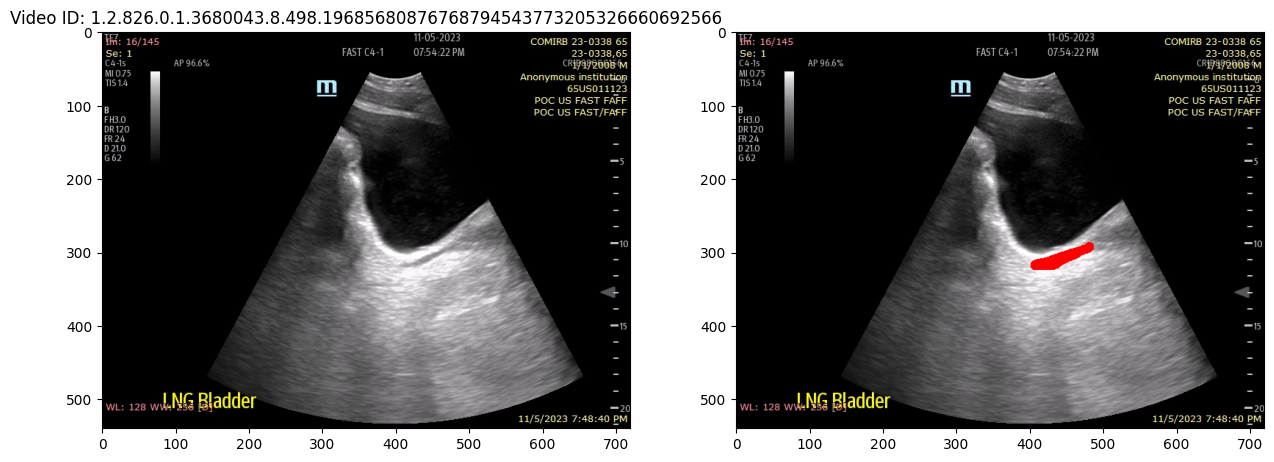

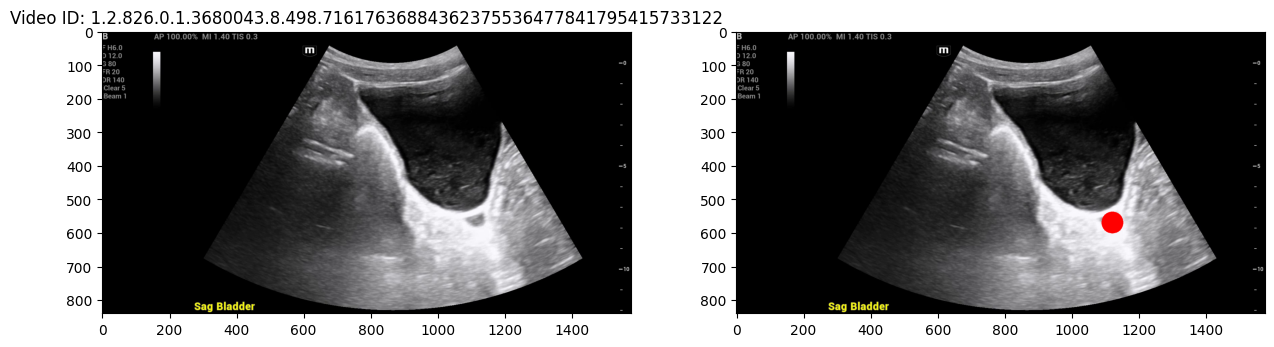

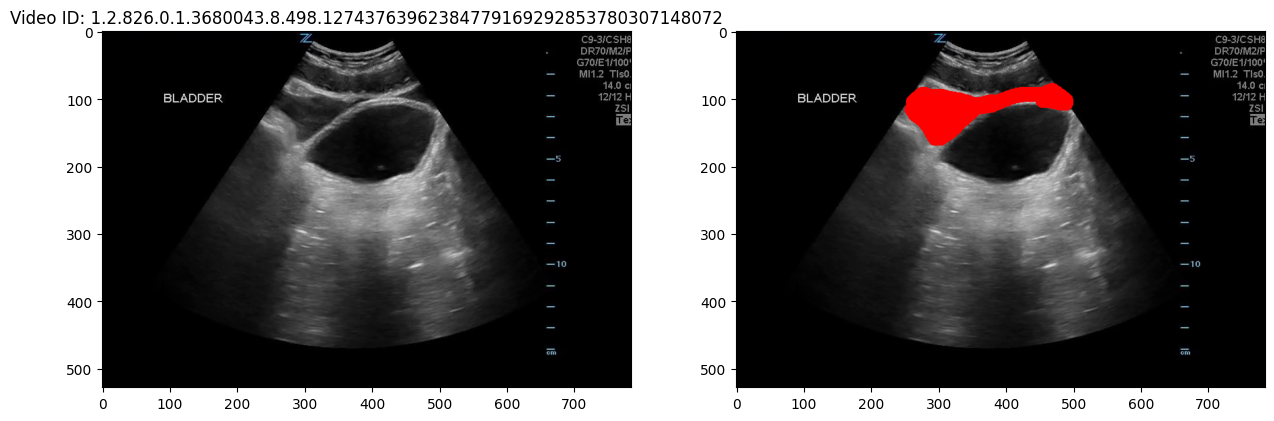

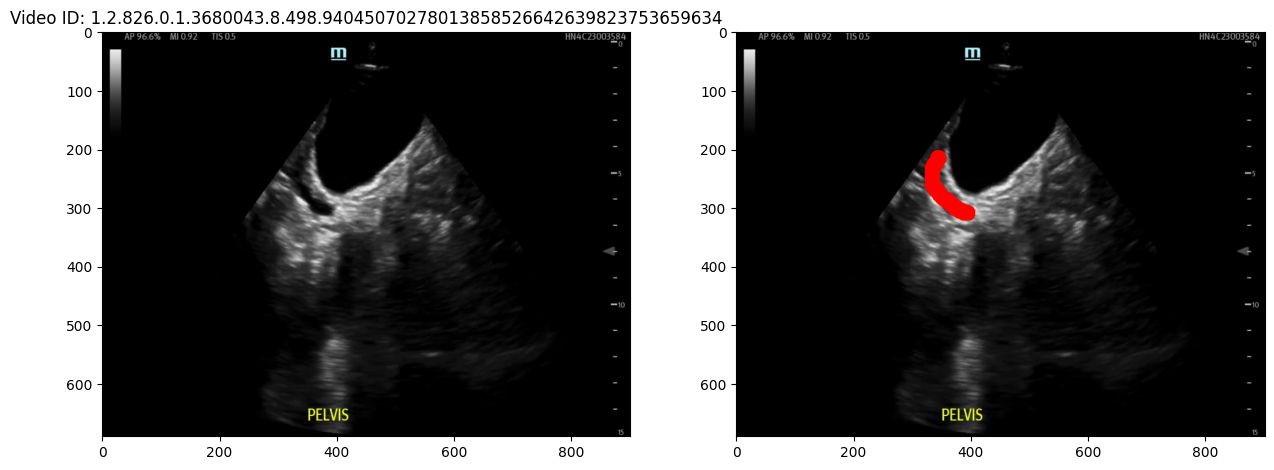

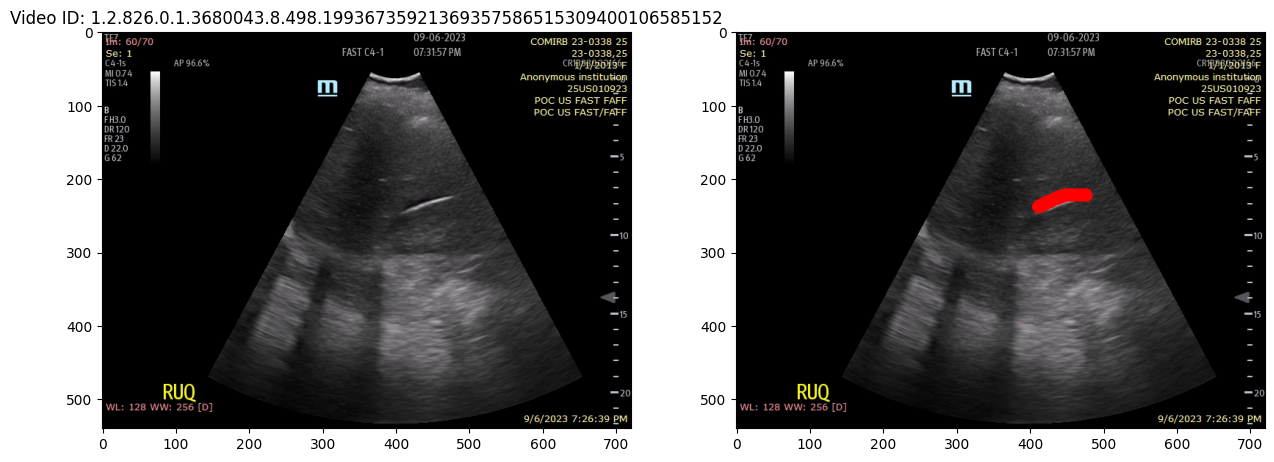

In [125]:

# Display selected annotations
for _, row in random_annotations.iterrows():
    display_annotation(row)

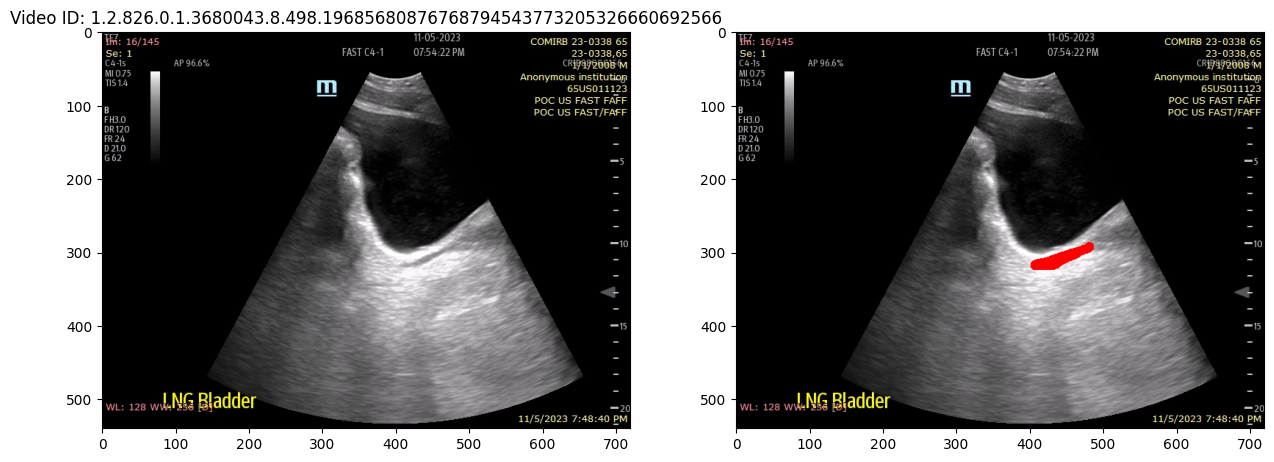

Processing video: data/mdai_ucsf_project_x9N2LJBZ_images_2024-06-27-212520/1.2.826.0.1.3680043.8.498.57725662815852545582797539432529109816/1.2.826.0.1.3680043.8.498.19685680876768794543773205326660692566.mp4, frame: 15
New good points: [[479.62158 287.8493 ]
 [479.09442 288.6801 ]
 [478.26166 288.73383]
 [476.75424 289.52615]
 [473.46368 290.27856]
 [473.8387  289.9113 ]
 [472.0615  290.98724]
 [471.6894  291.26575]
 [468.95212 292.66846]
 [467.6794  293.72455]
 [463.0597  294.63797]
 [462.45163 295.32635]
 [461.0732  295.09824]
 [460.3445  295.9696 ]
 [456.77048 295.6584 ]
 [455.77872 296.63025]
 [454.6904  296.6154 ]
 [453.3046  297.76025]
 [449.9977  298.07874]
 [449.0539  299.15567]
 [447.30087 299.03165]
 [445.92963 300.29095]
 [442.8873  300.11932]
 [441.45197 301.35434]
 [439.16068 301.30453]
 [438.11075 302.25253]
 [437.06332 302.1565 ]
 [436.69696 302.92963]
 [434.87134 302.64563]
 [436.84106 302.6237 ]
 [437.31763 301.48758]
 [435.12555 303.11124]
 [432.35446 303.2034 ]
 [42

: 

In [126]:
# Define feature parameters for goodFeaturesToTrack
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Define parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

def track_free_fluid(annotation):
    video_path = annotation['video_path']
    frame_number = int(annotation['frameNumber'])
    foreground = annotation['data']['foreground']

    print(f"Processing video: {video_path}, frame: {frame_number}")

    cap = cv2.VideoCapture(video_path)

    # Move to the annotated frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, old_frame = cap.read()

    if not ret:
        print(f"Failed to read the frame number {frame_number} from the video.")
        return

    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

    # Combine all shapes into a single list of points
    all_points = [point for shape in foreground for point in shape]
    p0 = np.array(all_points, np.float32).reshape(-1, 1, 2)

    # print(f"Initial points for tracking (p0): {p0}")

    mask = np.zeros_like(old_frame)

    while True:
        ret, frame = cap.read()
        if not ret:
            print("No more frames to read or end of video reached.")
            break

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        if p1 is None or st is None:
            print("Optical flow failed or no features found.")
            break

        # Select good points
        good_new = p1[st == 1]
        good_old = p0[st == 1]

        print(f"New good points: {good_new}")
        print(f"Old good points: {good_old}")

        if len(good_new) == 0 or len(good_old) == 0:
            print("No good points found.")
            break

        # Draw the tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            print(f"Drawing line: start=({a}, {b}), end=({c}, {d})")
            a, b, c, d = int(a), int(b), int(c), int(d)
            frame = cv2.line(frame, (a, b), (c, d), (0, 255, 0), 2)
            frame = cv2.circle(frame, (a, b), 5, (0, 255, 0), -1)

        img = frame

        cv2.imshow('frame', img)
        if cv2.waitKey(30) & 0xFF == 27:
            print("Stopped by user.")
            break

        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

    cap.release()
    cv2.destroyAllWindows()

# Example usage
for _, annotation in random_annotations.iterrows():
    display_annotation(annotation)
    track_free_fluid(annotation)
    break


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define feature parameters for goodFeaturesToTrack
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Define parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Confidence threshold for dropping points with high error
confidence_threshold = 1.0

def track_free_fluid(annotation):
    video_path = annotation['video_path']
    frame_number = int(annotation['frameNumber'])
    foreground = annotation['data']['foreground']

    print(f"Processing video: {video_path}, frame: {frame_number}")

    cap = cv2.VideoCapture(video_path)

    # Move to the annotated frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, old_frame = cap.read()

    if not ret:
        print(f"Failed to read the frame number {frame_number} from the video.")
        return

    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

    # Combine all shapes into a single list of points
    all_points = [point for shape in foreground for point in shape]
    p0 = np.array(all_points, np.float32).reshape(-1, 1, 2)

    # print(f"Initial points for tracking (p0): {p0}")

    mask = np.zeros_like(old_frame)

    while True:
        ret, frame = cap.read()
        if not ret:
            print("No more frames to read or end of video reached.")
            break

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        if p1 is None or st is None:
            print("Optical flow failed or no features found.")
            break

        # Select good points
        good_new = p1[st == 1]
        good_old = p0[st == 1]
        errors = err[st == 1]

        print(f"New good points: {good_new}")
        print(f"Old good points: {good_old}")

        if len(good_new) == 0 or len(good_old) == 0:
            print("No good points found.")
            break

        # Filter out points with high error
        valid_new = []
        valid_old = []
        for new, old, e in zip(good_new, good_old, errors):
            if e < confidence_threshold:
                valid_new.append(new)
                valid_old.append(old)
                a, b = new.ravel()
                c, d = old.ravel()
                frame = cv2.line(frame, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
                frame = cv2.circle(frame, (int(a), int(b)), 5, (0, 255, 0), -1)

        if len(valid_new) == 0 or len(valid_old) == 0:
            print("No valid points found.")
            break

        good_new = np.array(valid_new).reshape(-1, 1, 2)
        good_old = np.array(valid_old).reshape(-1, 1, 2)

        img = frame

        cv2.imshow('frame', img)
        if cv2.waitKey(30) & 0xFF == 27:
            print("Stopped by user.")
            break

        old_gray = frame_gray.copy()
        p0 = good_new

    cap.release()
    cv2.destroyAllWindows()

# Example usage
for _, annotation in random_annotations.iterrows():
    display_annotation(annotation)
    track_free_fluid(annotation)
    break
